In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.integrate import quad

import lilguys as lguys
from lilguys import units as lu
import arya
from glob import glob as glob


In [138]:
def get_Vc(snap, r):
    n = np.sum(snap.r < r)
    vs =  np.sqrt(n * snap.m/r) 
    return vs * lu.V_0

In [158]:
np.percentile(snap0.r, 0)

0.09921403974294662

In [179]:
def get_most_bound(snap, percent_keep=95, rmax=1, verbose=False):
    p0 = np.mean(snap.pos)
    shifted = snap.shift(-p0)
    r = np.max(shifted.r)
    filt = shifted.r < r
    while r > rmax:
        shifted = snap.shift(-p0)
        r = np.percentile(shifted.r[filt], percent_keep)
        filt = shifted.r < r
        if verbose:
            print(np.sum(filt))
        p0 = np.mean(snap.pos[filt], axis=0)
        v0 = np.mean(snap.vel[filt], axis=0)
    return p0, v0

In [140]:
def get_Vmax(snap, rs=np.linspace(0.25, 10, 100)):
    vs = [get_Vc(snap, r) for r in rs]
    idx_max = np.argmax(vs)
    return vs[idx_max], rs[idx_max]

In [141]:
filenames = glob("orbits/out/snapshot*.hdf5")
Nf = len(filenames)

In [142]:
s = lguys.Snapshot(np.zeros([1,3]), np.zeros([1,3]), m=1e-8, )

In [107]:
snap0 = lguys.Snapshot.file("orbits/out_old/snapshot_000.hdf5", potentials=False, accelerations=False)

In [143]:
snap_i = lguys.Snapshot.file(filenames[1])
snap_f = lguys.Snapshot.file(filenames[-1])

In [144]:
np.sum(lguys.profile.get_energy(snap_f))

-9167.351

In [145]:
np.sum(lguys.profile.get_energy(snap_i))

-9230.544

In [181]:
snap_xs = np.empty((Nf, 3))
v_disp = np.empty((Nf))
rs = np.empty(Nf)
Rs = 2

for i in range(Nf):
    snap = lguys.Snapshot.file(filenames[i])
    # p0 = np.mean(snap.pos, axis=0)
    # v0 = np.mean(snap.vel, axis=0)
    p0, v0 = get_most_bound(snap)
    snap = snap.shift(-p0, -v0)
    snap_xs[i] = p0
    #filt = np.isin(IDs, ID_stars)
    v_disp[i], rs[i] = get_Vmax(snap)

/cosma/local/Python/3.10.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cosma/local/Python/3.10.1/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


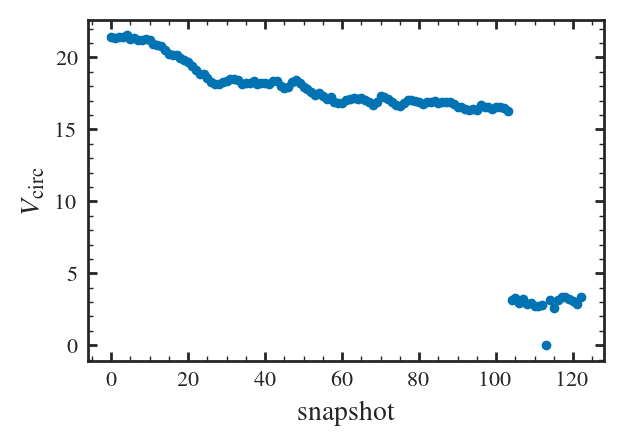

In [182]:
plt.scatter(np.arange(Nf), v_disp)
plt.xlabel("snapshot")
plt.ylabel(r"$V_{\rm circ}$")
plt.savefig("figures/v_circ.pdf")

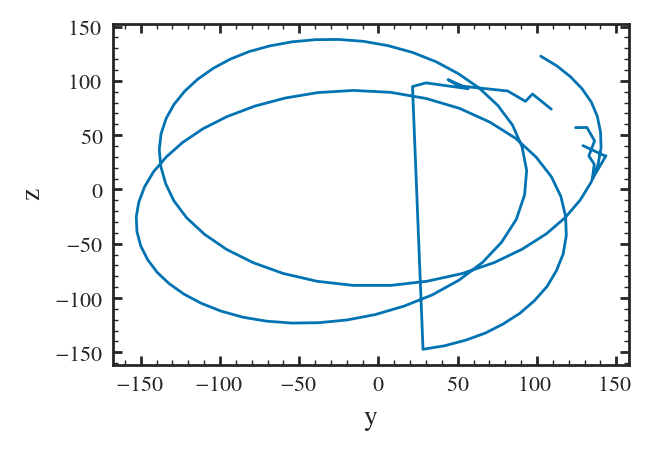

In [183]:
plt.plot(snap_xs[:, 1], snap_xs[:, 2])
plt.xlabel("y")
plt.ylabel("z")
plt.savefig("center_orbit.pdf")

In [95]:
import matplotlib.animation

In [96]:
snap0 = lguys.Snapshot.file(filenames[0], potentials=False, accelerations=False)

In [ ]:
snap_f.potential

array([-1.2286721 , -1.2666756 , -1.2422743 , ..., -1.1366302 ,
       -0.65697914, -0.6773503 ], dtype=float32)

MovieWriter ffmpeg unavailable; using Pillow instead.


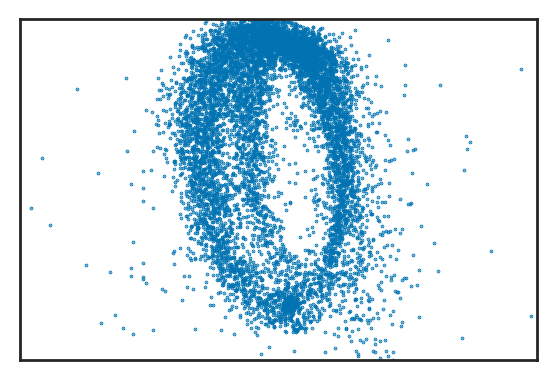

In [97]:
fig = plt.figure()

scat = plt.scatter(snap0.x, snap0.y, s=0.1)

plt.xlim(-180, 160)
plt.ylim(-150, 150)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    snap = lguys.Snapshot.file(filenames[i], potentials=False, accelerations=False
                              )
    # snap = lguys.profile.center_snapshot(snap)
    scat.set_offsets(np.array([snap.x, snap.y]).transpose())
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(Nf),
                                  fargs=(scat,))

ani.save("figures/orbit.gif", dpi=200)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


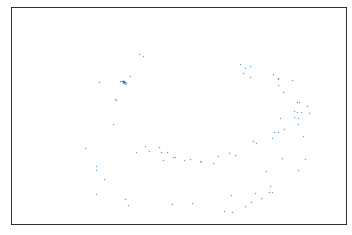

In [717]:
x, y, z = get_xy(f0)
IDs = f0["PartType1/ParticleIDs"][()]
filt = np.isin(IDs, ID_stars)

fig = plt.figure()
scat = plt.scatter(y[filt], z[filt], s=0.1)

plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    f = h5py.File(fnames[i], "r")
    IDs = f0["PartType1/ParticleIDs"][()]
    filt = np.isin(IDs, ID_stars)

    x, y, z = get_xy(f)
    scat.set_offsets(np.array([y[filt], z[filt]]).transpose())
    f.close()
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(len(fnames)),
                                  fargs=(scat,))

ani.save("stars.gif", dpi=200)
plt.show()

In [7]:
snap0 = lguys.Snapshot.file(filenames[0])


NameError: name 'filenames' is not defined

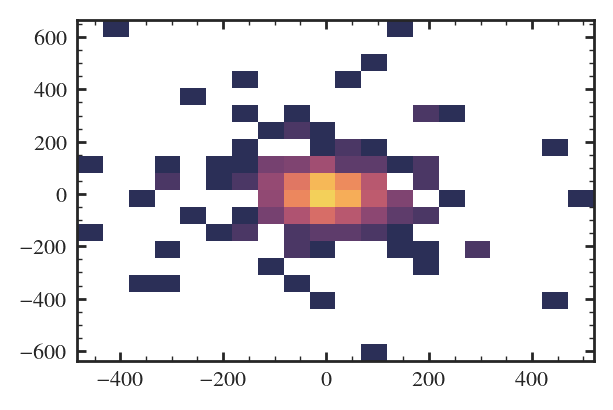

In [97]:
plt.hist2d(s1.x, s1.y, norm=mpl.colors.LogNorm(1, 1e3), cmin=1, bins=20);


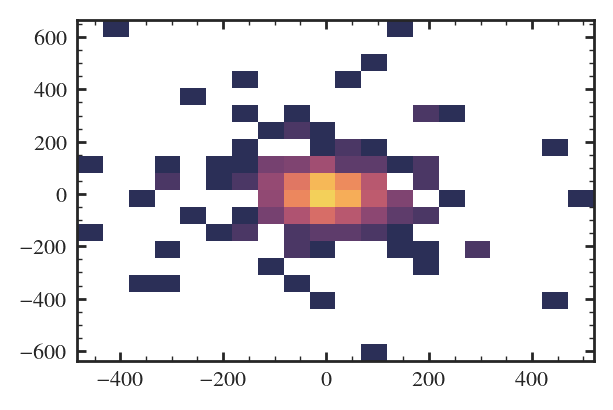

In [98]:
plt.hist2d(s2.x, s2.y, norm=mpl.colors.LogNorm(1, 1e3), cmin=1, bins=20);


In [85]:
def get_mid_coord(snap):
    p0, v0 = lguys.profile.get_most_bound(snap)
    phase = lguys.coords.phase_point(*p0, *v0)
    return lguys.coords.to_sky(phase)

In [86]:
mid_obs = get_mid_coord(s1)

In [88]:
obs = lguys.coords.to_sky(s1)

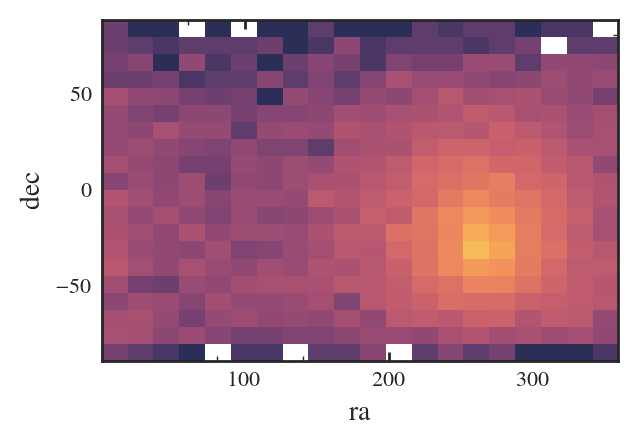

In [92]:
d_deg = 100
ra_0 = mid_obs.ra
dec_0 = mid_obs.dec

plt.hist2d(obs.ra, obs.dec, 20,norm=mpl.colors.LogNorm(1, 1e3))
          # range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.savefig("skyproj_init.pdf")

In [157]:
filename_f = "orbits/out/snapshot_121.hdf5"
snap_f = lguys.Snapshot.file(filename_f)

In [83]:
mid_obs = get_mid_coord(s1)
obs = lguys.coords.to_sky(s1)
d_deg = 10
ra_0 = mid_obs.ra
dec_0 = mid_obs.dec

plt.hist2d(obs.ra, obs.dec, 20,norm=mpl.colors.LogNorm(1, 1e3),
           range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.savefig("skyproj_fin.pdf")

NameError: name 'get_most_bound' is not defined

Text(0, 0.5, 'v')

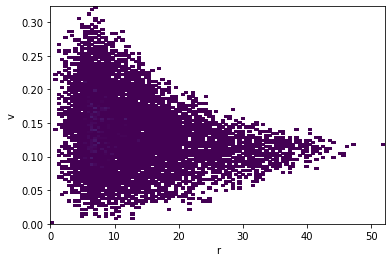

In [ ]:
plt.hist2d(r, v, norm=mpl.colors.LogNorm(10, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")

Text(0.5, 0, 'R')

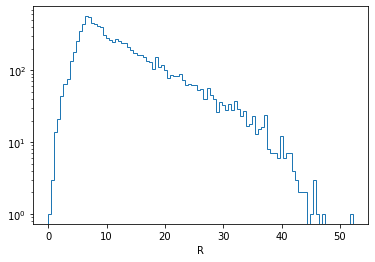

In [267]:
plt.hist(r, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

In [268]:
f1 = h5py.File("isolation/out/snapshot_001.hdf5", "r")

In [269]:
pos1 = f1["PartType1/Coordinates"][()]
x1 = pos1[:, 0]
y1 = pos1[:, 1]
z1 = pos1[:, 2]
r1 = np.sqrt(x1**2 + y1**2 + z1**2)
vel1 = f1["PartType1/Velocities"][()]
vx1 = vel1[:, 0]
xy1 = vel1[:, 1]
vz1 = vel1[:, 2]
v1 = np.sum(vel1**2, axis=1)
r1 = np.sum(pos1**2, axis=1)

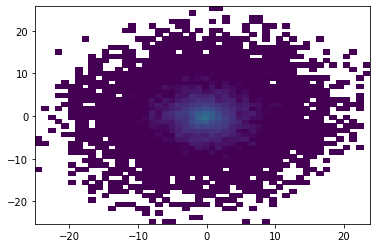

In [270]:
dx = 100
n_bin = 50
plt.hist2d(s, y1, norm=mpl.colors.LogNorm(10, 1e5), cmin=1, bins=50);

Text(0.5, 0, 'R')

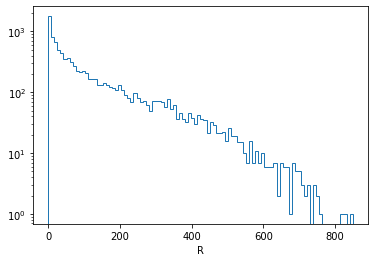

In [271]:
plt.hist(r1, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

Text(0, 0.5, 'v')

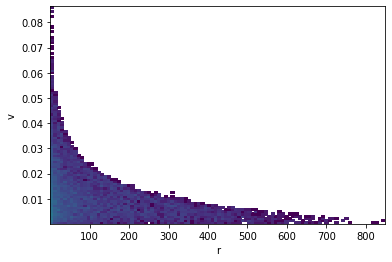

In [272]:
dx = 30
dy = 1e-10
n_bin = 50
plt.hist2d(r1, v1, norm=mpl.colors.LogNorm(1, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")

# Calculate stellar probabilities

In [184]:
from lilguys import profile

In [27]:
snap0 = lguys.Snapshot.file(filenames[1])

In [112]:
G = 1
EPSREL = 1e-7

# profile scale radius and index
n = 1
rsS = 2 # kpc, input

EN = 20
DF_Nr = 20

In [132]:
snap0 = lguys.profile.center_snapshot(snap0)

r = snap0.r

idx_sort = np.argsort(r)

m = snap0.m
N = len(r)
Mr = m * np.arange(N)

N = len(r)
Φ = snap0.potential
IDs = snap0.IDs
# Phi = -G * (Mr/r[idx_sort] + np.cumsum(m / r[idx_sort][::-1])[::-1])

In [133]:
E_kin = 1/2 * np.sum(snap0.vel**2, axis=1)
E_kin = np.array(E_kin)
Etot = E_kin + Φ[np.argsort(idx_sort)]

In [134]:
def ρ_star(r):
    return np.exp(-(r/rsS)**(1/n))

def ρ_s_int(r):
    return 4*np.pi * r**2 * ρ_star(r)

M_star = quad(ρ_s_int, 0., np.inf)[0]
M_star_r = np.vectorize(lambda x: quad(ρ_s_int, 0, x)[0])

In [135]:
DF_r_max = np.max(r)
DF_r_min = np.min(r[r > 2*EPSREL])
bins = np.logspace(np.log10(DF_r_min), np.log10(DF_r_max), num=DF_Nr)
DFr = 1/2 * (bins[1:] + bins[:-1])

In [136]:
NinS = quad(ρ_s_int, 0, DF_r_min)[0]  / M_star

NoutS = 1 - quad(ρ_s_int, 0, DF_r_max)[0]/M_star

In [186]:
prof = lguys.profile.Profile(snap_i)

shifting by [ 27.53806 112.70086 114.09685], [-0.19871369  0.44847867 -0.44212085]


In [187]:
prof_f = lguys.profile.Profile(snap_f)

shifting by [-22.352058 111.51024  -34.364773], [-0.20627838 -0.11326316 -0.63119394]


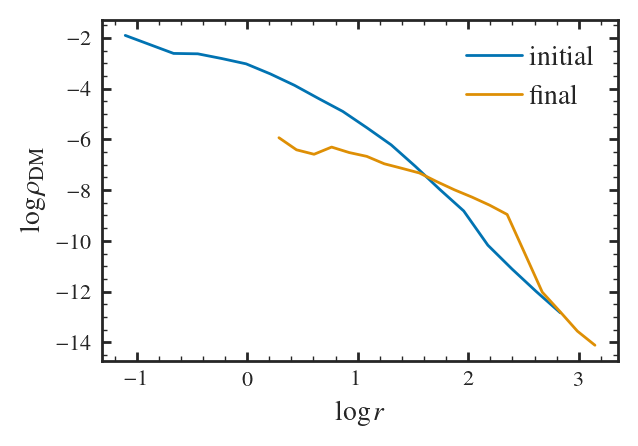

In [189]:
plt.plot(np.log10(prof.r), np.log10(prof.nu_DM), label="initial")

plt.plot(np.log10(prof_f.r), np.log10(prof_f.nu_DM), label="final")
plt.xlabel(r"$\log r$")
plt.ylabel(r"$\log \rho_{\rm DM}$")

plt.legend()
plt.savefig("figures/dm_density.pdf")

In [149]:
M_star_r

In [146]:
M_star

201.06192982974676

In [138]:
psi = - np.interp(DFr, r[idx_sort], Φ)

nuDM, edges = np.histogram(r, bins=bins)
dV = (4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3))
nuDM = nuDM * m / dV

DF_rm = 1/2*(edges[1:] + edges[:-1])

In [43]:
nuS = ρ_star(DF_rm) / M_star

In [150]:
M_cum = np.interp(DF_rm, r[idx_sort], Mr)
M_star_cum = M_star_r(DF_rm)

In [151]:
M_star_cum

array([4.86570781e-03, 1.28998762e-02, 3.39930305e-02, 8.88258402e-02,
       2.29417168e-01, 5.83058259e-01, 1.44925009e+00, 3.49390168e+00,
       8.07903725e+00, 1.76553687e+01, 3.57800928e+01, 6.57173657e+01,
       1.06701966e+02, 1.50054116e+02, 1.82282203e+02, 1.97116944e+02,
       2.00690622e+02, 2.01050689e+02, 2.01061861e+02])

/tmp/ipykernel_59075/1652554652.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")


Text(0, 0.5, '$\\log_{10} \\nu$')

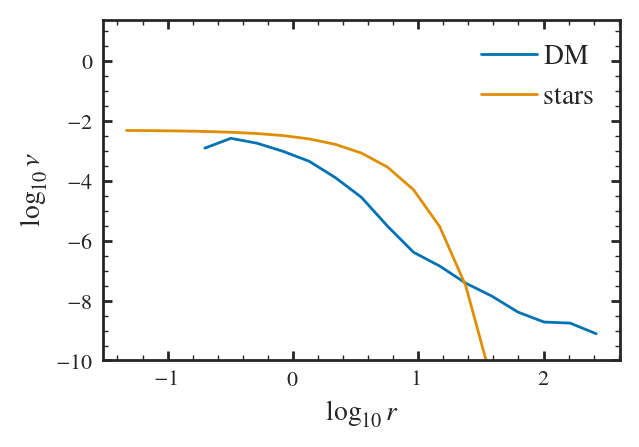

In [63]:
plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")
plt.plot(np.log10(DF_rm), np.log10(nuS), label="stars")
plt.legend()
plt.ylim(-10)
plt.xlabel(r"$\log_{10} r$")
plt.ylabel(r"$\log_{10} \nu$")

Text(0.5, 0, '$\\log r$')

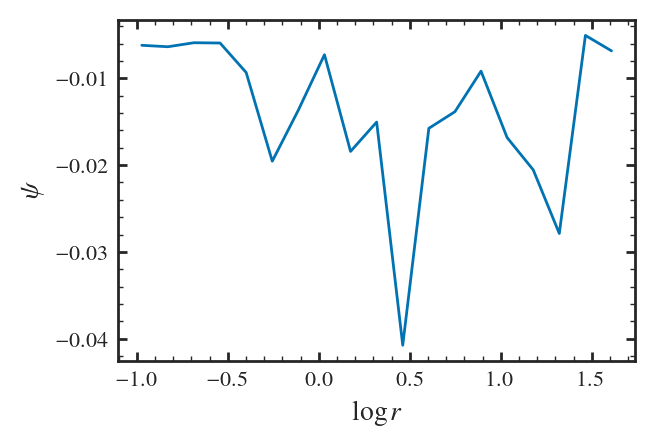

In [160]:
plt.plot(np.log10(DF_rm), -psi)
plt.ylabel(r"$\psi$")
plt.xlabel(r"$\log r$")

In [49]:
dndpDM   = np.gradient(nuDM,   psi)
d2nd2pDM = np.gradient(dndpDM, psi)
dndpS   = np.gradient(nuS,   psi)
d2nd2pS = np.gradient(dndpS, psi)

In [50]:
fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(
fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) )


In [51]:
E_max = psi[0]
E_min = E_max / EN

In [52]:
E = np.linspace(E_min, E_max, EN)

In [53]:
DF_stars = fS(E)

In [54]:
DF_DM = fDM(E)

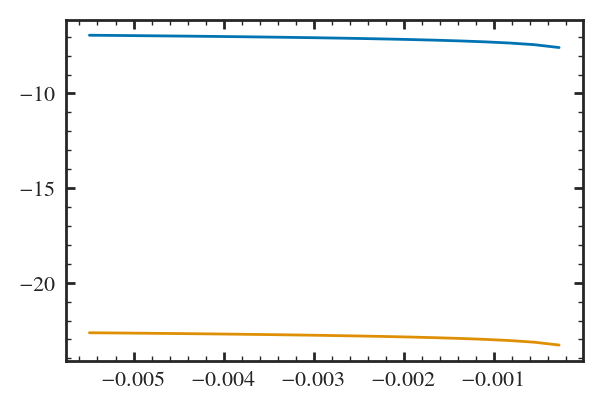

In [55]:
# plot DF vs -E
plt.plot(-E, np.log10(DF_DM))
plt.plot(-E, np.log10(DF_stars))

In [56]:
probs = np.interp(-Etot, E, DF_stars) / np.interp(-Etot, E, DF_DM)

In [57]:
probs /= np.sum(probs)

In [58]:
nuS_Nbody, edges = np.histogram(r, weights=probs, bins=bins)
nuS_Nbody = nuS_Nbody / dV

/tmp/ipykernel_59075/1322621873.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))


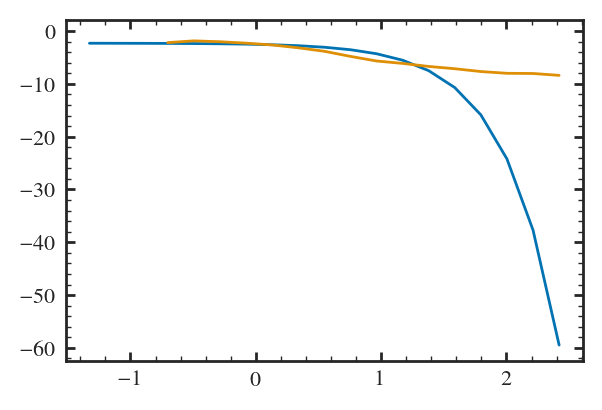

In [59]:
plt.plot(np.log10(DF_rm), np.log10(nuS))
plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))

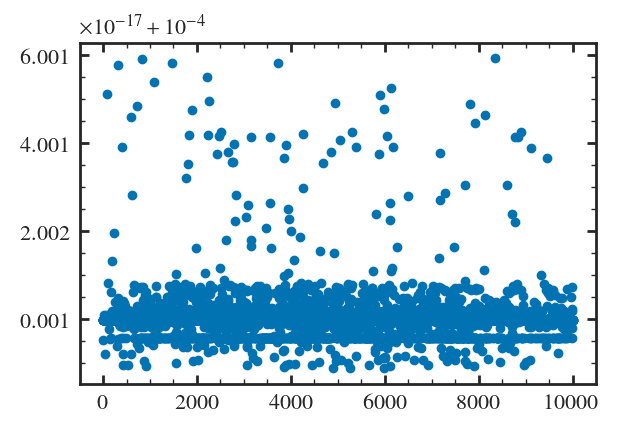

In [60]:
plt.scatter(IDs, probs)

In [61]:
Ns = 100

ID_stars = IDs[probs*Ns > np.random.uniform(size=N)]

In [62]:
ID_stars

array([9814, 8471, 3691, 5297, 2915, 6679, 5207, 6486, 3669, 7361, 9788,
       8769, 7255, 7646, 6513, 1543, 2336, 1533, 4080, 1055, 2295, 1440,
       1867, 2863, 5183, 4634, 4880, 6890, 9360, 7777, 7174, 9962, 8208,
       6534, 5928, 9472, 5521, 4499, 7210, 7701, 9153, 3680, 6614, 9127,
       8155, 8125, 5996, 7712, 5657, 2278, 5820, 4552,  711, 2910, 2069,
       2289, 7270, 3193, 3283, 9453, 9048, 9530, 9400, 9992, 8409, 5163,
       4845, 4037, 1293, 5599, 4641, 2518, 1755, 1660, 3013, 3946, 7863,
       9310, 7928, 5319, 6077, 4908, 4313, 3860, 2984,  614, 3260, 3725,
         93,  464,  934,  765,   33, 4467, 1125, 2377, 9748, 9897, 9281,
       4311, 4220, 6038, 6856, 8836, 8210, 9557, 9970, 6976, 4241],
      dtype=uint32)